In [0]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import pandas as pd
import io

from pathlib import Path

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

from IPython.display import display
pd.options.display.max_columns = 50
pd.options.display.html.table_schema = True

## Preprocessing

In [15]:
#path = Path('datasets/stocks/mbb.csv')
path = Path('mbb.csv')

dataset = pd.read_csv(path, parse_dates=True)
df = dataset.copy()
df.rename(index=str, columns={"Price":"Close"}, inplace=True)
df.head(10)

# Convert the date column
df['Date'] = pd.to_datetime(df['Date'])

df.sort_values(by=['Date'], ascending=True, inplace=True)
df.set_index(['Date'], inplace=True)    
display(df.head(10))
df.info()

,Close,Open,High,Low,Vol.,Change %
Date,,,,,,
2011-09-02,8.72,9.00,9.00,8.69,12.92M,0.00%
2011-09-05,8.73,8.72,8.75,8.70,12.39M,0.11%
2011-09-06,8.68,8.72,8.72,8.68,11.48M,-0.57%
2011-09-07,8.67,8.70,8.70,8.64,5.73M,-0.12%
2011-09-08,8.69,8.71,8.74,8.67,4.69M,0.23%
2011-09-09,8.69,8.70,8.70,8.68,5.09M,0.00%
2011-09-12,8.61,8.65,8.68,8.55,8.59M,-0.92%
2011-09-13,8.60,8.58,8.61,8.55,3.62M,-0.12%
2011-09-14,8.60,8.64,8.64,8.57,10.24M,0.00%


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1893 entries, 2011-09-02 to 2019-05-24
Data columns (total 6 columns):
Close       1893 non-null float64
Open        1893 non-null float64
High        1893 non-null float64
Low         1893 non-null float64
Vol.        1893 non-null object
Change %    1893 non-null object
dtypes: float64(4), object(2)
memory usage: 103.5+ KB


In [16]:
df.isna().any()

Close       False
Open        False
High        False
Low         False
Vol.        False
Change %    False
dtype: bool

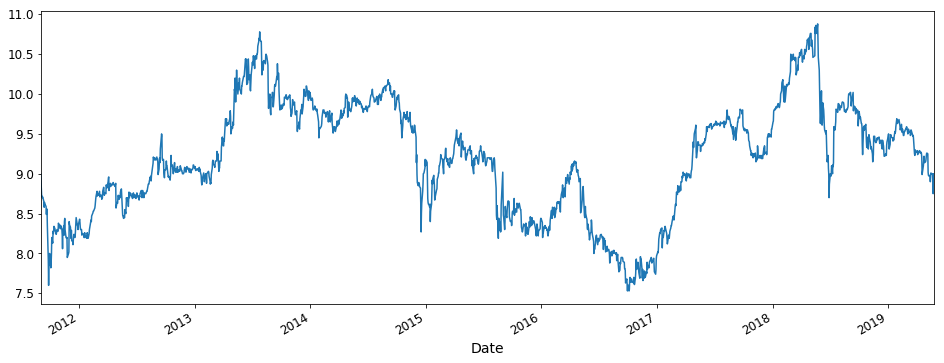

In [17]:
df['Open'].plot(figsize=(16,6))

### 7 days rolling means

In [18]:
df = df[['Close', 'Open', 'High', 'Low']]
df.rolling(7).mean().head(8)

,Close,Open,High,Low
Date,,,,
2011-09-02,NaN,NaN,NaN,NaN
2011-09-05,NaN,NaN,NaN,NaN
2011-09-06,NaN,NaN,NaN,NaN
2011-09-07,NaN,NaN,NaN,NaN
2011-09-08,NaN,NaN,NaN,NaN
2011-09-09,NaN,NaN,NaN,NaN
2011-09-12,8.684286,8.742857,8.755714,8.658571
2011-09-13,8.667143,8.682857,8.700000,8.638571


In [19]:
df.head(3)

,Close,Open,High,Low
Date,,,,
2011-09-02,8.72,9.00,9.00,8.69
2011-09-05,8.73,8.72,8.75,8.70
2011-09-06,8.68,8.72,8.72,8.68


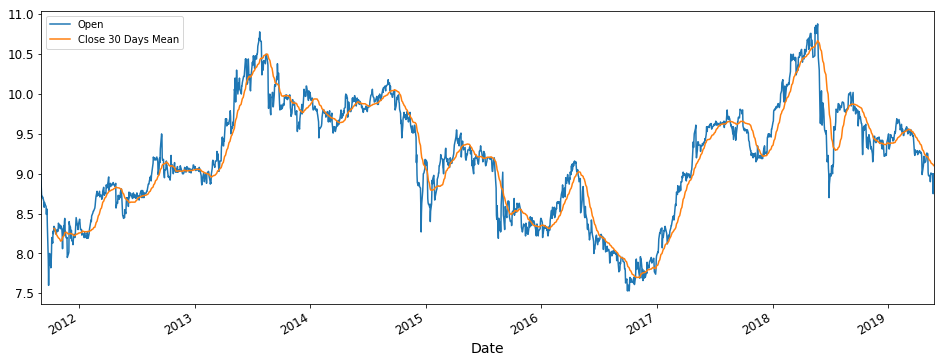

In [20]:
# Open vs Close 30 days mean
df['Close 30 Days Mean'] = df['Close'].rolling(window=30).mean()
df[['Open', 'Close 30 Days Mean']].plot(figsize=(16,6))
#df.rolling(window=30).mean()['Close'].plot()

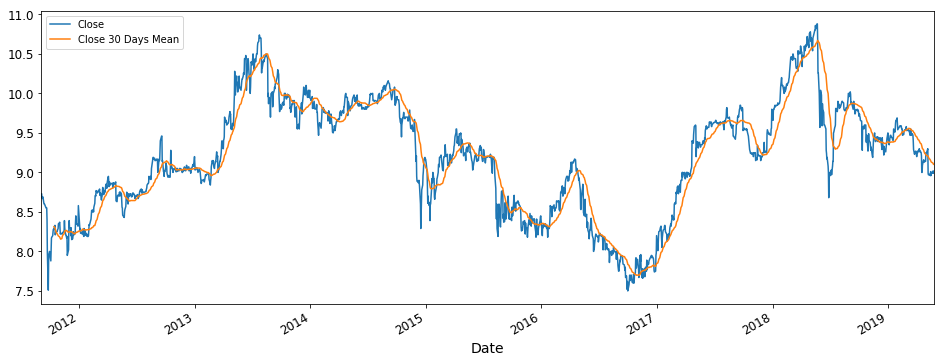

In [21]:
# df['Close: 30 Day Mean'] = df['Price'].rolling(window=30).mean()
df[['Close','Close 30 Days Mean']].plot(figsize=(16,6))

### Expanding

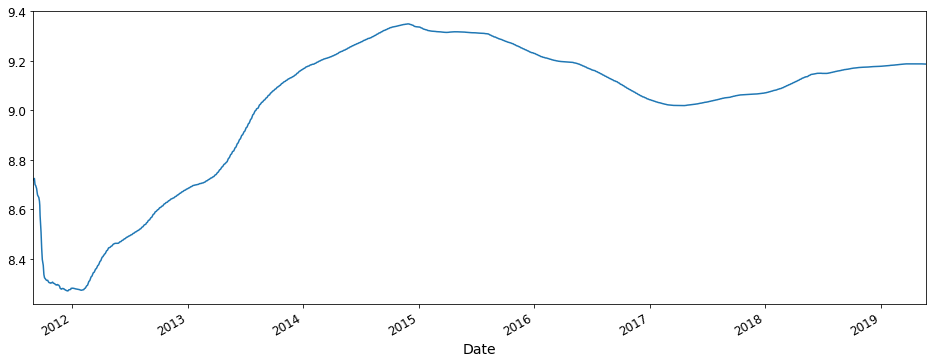

In [22]:
# Optional specify a minimum number of periods
df['Close'].expanding(min_periods=1).mean().plot(figsize=(16,6))

### Group into X days prices

In [23]:
df_temp = df.copy()
df_temp.reset_index(inplace=True)
number_of_days = 5
df_temp.head(5)

,Date,Close,Open,High,Low,Close 30 Days Mean
0,2011-09-02,8.72,9.00,9.00,8.69,NaN
1,2011-09-05,8.73,8.72,8.75,8.70,NaN
2,2011-09-06,8.68,8.72,8.72,8.68,NaN
3,2011-09-07,8.67,8.70,8.70,8.64,NaN
4,2011-09-08,8.69,8.71,8.74,8.67,NaN


In [24]:
df_temp['GroupId'] = df_temp.index
df_temp['GroupId'] = df_temp.apply(lambda x: df_temp['GroupId'] // number_of_days)
df_grouped_mean = df_temp.groupby(['GroupId'], as_index=False).mean()
display(df.head(10), len(df))
display(df_grouped_mean.head(10), len(df_grouped_mean))

,Close,Open,High,Low,Close 30 Days Mean
Date,,,,,
2011-09-02,8.72,9.00,9.00,8.69,NaN
2011-09-05,8.73,8.72,8.75,8.70,NaN
2011-09-06,8.68,8.72,8.72,8.68,NaN
2011-09-07,8.67,8.70,8.70,8.64,NaN
2011-09-08,8.69,8.71,8.74,8.67,NaN
2011-09-09,8.69,8.70,8.70,8.68,NaN
2011-09-12,8.61,8.65,8.68,8.55,NaN
2011-09-13,8.60,8.58,8.61,8.55,NaN
2011-09-14,8.60,8.64,8.64,8.57,NaN


1893

,GroupId,Close,Open,High,Low,Close 30 Days Mean
0,0,8.698,8.770,8.782,8.676,NaN
1,1,8.618,8.638,8.650,8.584,NaN
2,2,8.408,8.508,8.526,8.352,NaN
3,3,7.866,7.856,7.996,7.698,NaN
4,4,8.030,7.972,8.086,7.906,NaN
5,5,8.260,8.256,8.300,8.212,8.313333
6,6,8.254,8.272,8.300,8.218,8.269000
7,7,8.304,8.318,8.358,8.278,8.204533
8,8,8.264,8.330,8.338,8.232,8.166467
9,9,8.244,8.230,8.282,8.178,8.207333


379

### Split to train and test data sets

In [25]:
df = df_grouped_mean

from sklearn.model_selection import train_test_split
training_set, test_set = train_test_split(df, test_size=0.20, shuffle=False)
display(len(training_set),training_set.head(10))
display(len(test_set), test_set.head(10))

303

,GroupId,Close,Open,High,Low,Close 30 Days Mean
0,0,8.698,8.770,8.782,8.676,NaN
1,1,8.618,8.638,8.650,8.584,NaN
2,2,8.408,8.508,8.526,8.352,NaN
3,3,7.866,7.856,7.996,7.698,NaN
4,4,8.030,7.972,8.086,7.906,NaN
5,5,8.260,8.256,8.300,8.212,8.313333
6,6,8.254,8.272,8.300,8.218,8.269000
7,7,8.304,8.318,8.358,8.278,8.204533
8,8,8.264,8.330,8.338,8.232,8.166467
9,9,8.244,8.230,8.282,8.178,8.207333


76

,GroupId,Close,Open,High,Low,Close 30 Days Mean
303,303,9.210,9.224,9.248,9.186,9.423667
304,304,9.220,9.238,9.346,9.152,9.340333
305,305,9.212,9.208,9.238,9.196,9.286067
306,306,9.200,9.204,9.230,9.166,9.233933
307,307,9.286,9.286,9.360,9.238,9.224533
308,308,9.356,9.294,9.396,9.274,9.233733
309,309,9.490,9.488,9.510,9.436,9.273933
310,310,9.608,9.544,9.632,9.504,9.329333
311,311,9.812,9.772,9.824,9.764,9.417533
312,312,9.846,9.834,9.862,9.824,9.524400


## Training

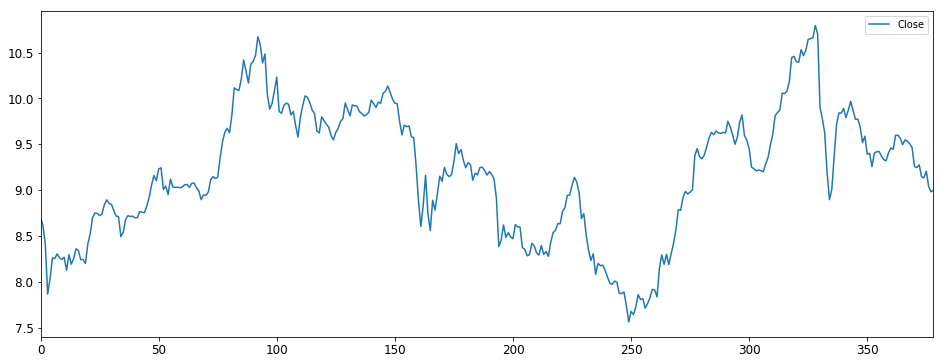

In [26]:
data = df[['Close']]
data.plot(y='Close', figsize=(16,6))

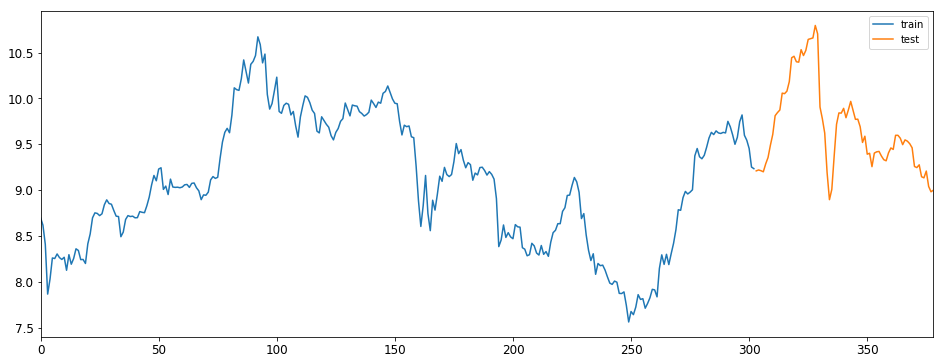

In [27]:
train = training_set[['Close']]
test = test_set[['Close']]

ax = train.plot(figsize=(16,6))
test.plot(ax=ax)
plt.legend(['train', 'test'])
plt.show()

### Normalize the data

In [0]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [29]:
train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)

for s in range(1,2):
    train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)
    test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)

#print(train_sc_df)
X_train = train_sc_df.dropna().drop('Y', axis=1)
y_train = train_sc_df.dropna().drop('X_1', axis=1)

X_test = test_sc_df.dropna().drop('Y', axis=1)
y_test = test_sc_df.dropna().drop('X_1', axis=1)

X_train = X_train.as_matrix()
y_train = y_train.as_matrix()

X_test = X_test.as_matrix()
y_test = y_test.as_matrix()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


### SVM

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


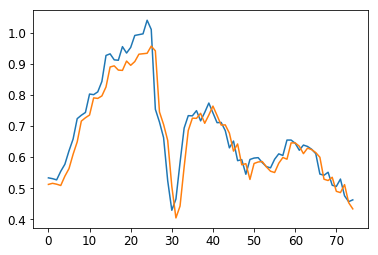

In [30]:
from sklearn.svm import SVR
regressor = SVR(kernel='rbf')
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

plt.plot(y_test)
plt.plot(y_pred)

### LSTM

In [0]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [32]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model

Using TensorFlow backend.


In [0]:
X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
#print(X_tr_t)

In [37]:
from keras.layers import LSTM
from sklearn.metrics import r2_score
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(7, input_shape=(1, X_train.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=200, batch_size=32, verbose=1, shuffle=False, callbacks=[early_stop])

y_pred_test_lstm = model_lstm.predict(X_tst_t)
y_train_pred_lstm = model_lstm.predict(X_tr_t)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))

Epoch 1/200
302/302 [==============================] - 1s 2ms/step - loss: 0.3737
Epoch 2/200
302/302 [==============================] - 0s 180us/step - loss: 0.3515
Epoch 3/200
302/302 [==============================] - 0s 172us/step - loss: 0.3304
Epoch 4/200
302/302 [==============================] - 0s 170us/step - loss: 0.3104
Epoch 5/200
302/302 [==============================] - 0s 178us/step - loss: 0.2914
Epoch 6/200
302/302 [==============================] - 0s 166us/step - loss: 0.2734
Epoch 7/200
302/302 [==============================] - 0s 173us/step - loss: 0.2564
Epoch 8/200
302/302 [==============================] - 0s 179us/step - loss: 0.2403
Epoch 9/200
302/302 [==============================] - 0s 177us/step - loss: 0.2250
Epoch 10/200
302/302 [==============================] - 0s 171us/step - loss: 0.2105
Epoch 11/200
302/302 [==============================] - 0s 178us/step - loss: 0.1967
Epoch 12/200
302/302 [==============================] - 0s 175us/step - loss

In [0]:
model_lstm.save('LSTM_NonShift.h5')

### Prediction

In [0]:
model_lstm = load_model('LSTM_NonShift.h5')

In [40]:
score_lstm= model_lstm.evaluate(X_tst_t, y_test, batch_size=32)


75/75 [==============================] - 0s 2ms/step


In [41]:
print('LSTM: %f'%score_lstm)

LSTM: 0.003062


In [0]:
y_pred_test_LSTM = model_lstm.predict(X_tst_t)

In [0]:
col1 = pd.DataFrame(y_test, columns=['True'])
#col2 = pd.DataFrame(y_pred_test_ANN, columns=['ANN_prediction'])
col3 = pd.DataFrame(y_pred_test_LSTM, columns=['LSTM_prediction'])
#col4 = pd.DataFrame(history.history['loss'], columns=['Loss_ANN'])
col5 = pd.DataFrame(history_model_lstm.history['loss'], columns=['Loss_LSTM'])
results = pd.concat([col1, col3, col5], axis=1)
results.to_excel('PredictionResults_ANN-LSTM_NonShift.xlsx')

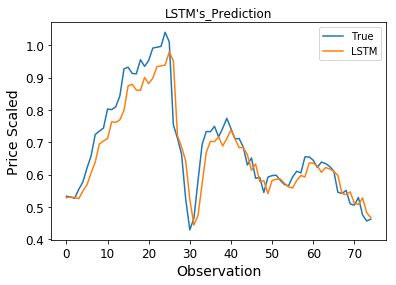

In [44]:
plt.plot(y_test, label='True')
plt.plot(y_pred_test_LSTM, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('Price Scaled')
plt.legend()
plt.show()

In [47]:
y_test_real = sc.inverse_transform(y_test)
display(len(y_test_real), y_test_real)

75

array([[ 9.22 ],
       [ 9.212],
       [ 9.2  ],
       [ 9.286],
       [ 9.356],
       [ 9.49 ],
       [ 9.608],
       [ 9.812],
       [ 9.846],
       [ 9.874],
       [10.058],
       [10.052],
       [10.08 ],
       [10.184],
       [10.444],
       [10.46 ],
       [10.4  ],
       [10.396],
       [10.532],
       [10.468],
       [10.524],
       [10.644],
       [10.652],
       [10.66 ],
       [10.796],
       [10.704],
       [ 9.906],
       [ 9.778],
       [ 9.622],
       [ 9.192],
       [ 8.896],
       [ 9.008],
       [ 9.372],
       [ 9.718],
       [ 9.842],
       [ 9.84 ],
       [ 9.892],
       [ 9.79 ],
       [ 9.874],
       [ 9.968],
       [ 9.87 ],
       [ 9.772],
       [ 9.774],
       [ 9.692],
       [ 9.52 ],
       [ 9.588],
       [ 9.392],
       [ 9.402],
       [ 9.256],
       [ 9.404],
       [ 9.418],
       [ 9.422],
       [ 9.372],
       [ 9.332],
       [ 9.32 ],
       [ 9.406],
       [ 9.46 ],
       [ 9.444],
       [ 9.598

In [48]:
y_test_predict = sc.inverse_transform(y_pred_test_LSTM)
display(len(y_test_predict), y_test_predict)

75

array([[ 9.20546  ],
       [ 9.213921 ],
       [ 9.207151 ],
       [ 9.197005 ],
       [ 9.269927 ],
       [ 9.32963  ],
       [ 9.444799 ],
       [ 9.547175 ],
       [ 9.721191 ],
       [ 9.750429 ],
       [ 9.774581 ],
       [ 9.934961 ],
       [ 9.929686 ],
       [ 9.954332 ],
       [10.046465 ],
       [10.280878 ],
       [10.295494 ],
       [10.240797 ],
       [10.237162 ],
       [10.361542 ],
       [10.30281  ],
       [10.35418  ],
       [10.465178 ],
       [10.472622 ],
       [10.480072 ],
       [10.607572 ],
       [10.521145 ],
       [ 9.802264 ],
       [ 9.692054 ],
       [ 9.5593815],
       [ 9.190246 ],
       [ 8.943    ],
       [ 9.035901 ],
       [ 9.343322 ],
       [ 9.640875 ],
       [ 9.746984 ],
       [ 9.745262 ],
       [ 9.790142 ],
       [ 9.702326 ],
       [ 9.774581 ],
       [ 9.856152 ],
       [ 9.771126 ],
       [ 9.686922 ],
       [ 9.688632 ],
       [ 9.618792 ],
       [ 9.470741 ],
       [ 9.52976  ],
       [ 9.36

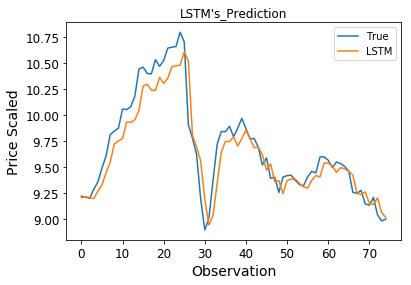

In [49]:
plt.plot(y_test_real, label='True')
plt.plot(y_test_predict, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('Price Scaled')
plt.legend()
plt.show()